In [ ]:
# This Notebook was authored by Naman Bansal
# https://github.com/nb4159
# https://www.kaggle.com/namanbansal4122
# https://www.linkedin.com/in/naman-bansal-aa723024b/

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16

In [2]:
base_directory = '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

# Segmentation of Forests in Satellite Images
- We will segment the forest areas in the satellite images
- Since we are going to segment multiple instances of forests present in an image and are not interested in identifying separate instances individually we will perform semantic segmentation


In [4]:
img_dim = 256

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_image_generator = image_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 16,
        seed=42,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 16,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 16,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 16,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 4342 images belonging to 1 classes.

Found 4342 images belonging to 1 classes.

Found 766 images belonging to 1 classes.

Found 766 images belonging to 1 classes.


In [5]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

# Visualization
- Image and its Corresponding Mask Image
- The white pixel areas are the regions of interest or the areas that we are interested to segment, i.e. in our case forests in an image
- The black pixels are the other regions that we are not interested in

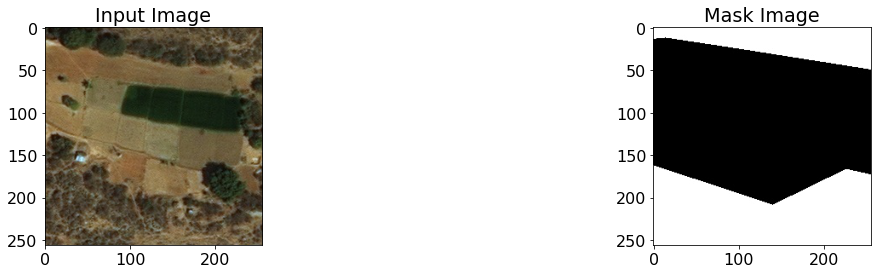

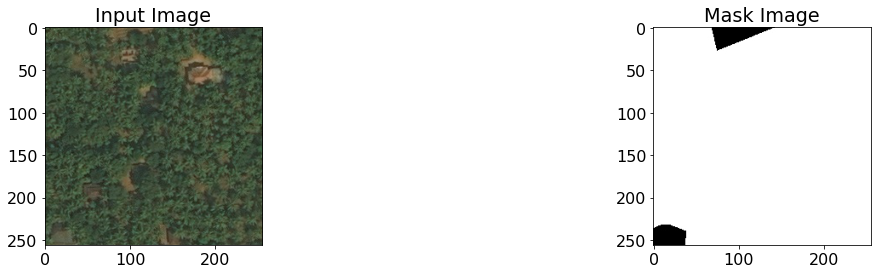

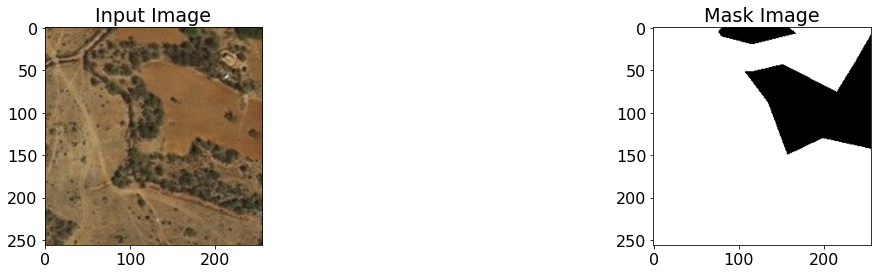

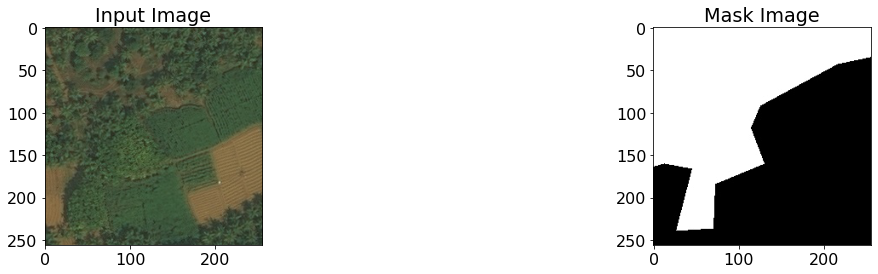

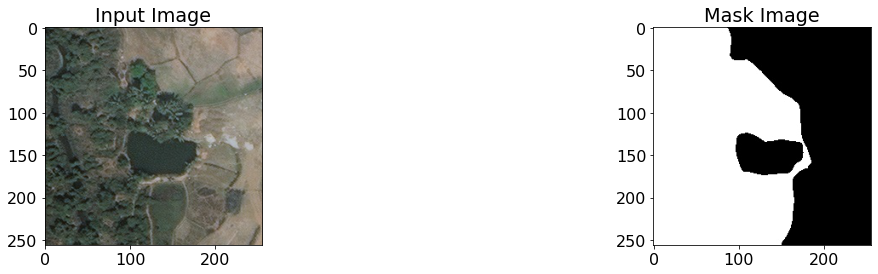

In [6]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

In [8]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same", kernel_initializer="he_normal")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet_plusplus(input_shape ,name="unet_plusplus"):
    inputs = Input(input_shape)
    
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name=name)
    return model




Model: "unet_plusplus"

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     


input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            

__________________________________________________________________________________________________

conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    

__________________________________________________________________________________________________

batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     

__________________________________________________________________________________________________

activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        

___________________________________________________________________________

In [12]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate

def linknet_encoder_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def linknet_decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_linknet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    e1 = linknet_encoder_block(inputs, 32)
    p1 = MaxPool2D((2, 2))(e1)
    e2 = linknet_encoder_block(p1, 64)
    p2 = MaxPool2D((2, 2))(e2)
    e3 = linknet_encoder_block(p2, 128)
    p3 = MaxPool2D((2, 2))(e3)
    e4 = linknet_encoder_block(p3, 256)
    p4 = MaxPool2D((2, 2))(e4)

    # Center block
    center = linknet_encoder_block(p4, 512)

    # Decoder
    d4 = linknet_decoder_block(center, e4, 256)
    d3 = linknet_decoder_block(d4, e3, 128)
    d2 = linknet_decoder_block(d3, e2, 64)
    d1 = linknet_decoder_block(d2, e1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d1)

    model = Model(inputs, outputs, name="linknet")
    return model


In [19]:
from tensorflow.keras.layers import Average, Input

# Build LinkNet model
input_shape = (256, 256, 3)  
linknet_model = build_linknet(input_shape)
unetplusplus_model = build_unet_plusplus(input_shape)

# input layer for the ensemble
ensemble_inputs = Input(input_shape)

linknet_output = linknet_model(ensemble_inputs)
unetplusplus_output = unetplusplus_model(ensemble_inputs)

average = Average()([linknet_output, unetplusplus_output])

ensemble_model = Model(inputs=ensemble_inputs, outputs=average, name="ensemble_model")

ensemble_model.summary()


Model: "ensemble_model"

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     


input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            

__________________________________________________________________________________________________

linknet (Functional)            (None, 256, 256, 1)  7771873     input_12[0][0]                   

__________________________________________________________________________________________________

unet_plusplus (Functional)      (None, 256, 256, 1)  31055297    input_12[0][0]                   

__________________________________________________________________________________________________

average_2 (Average)             (None, 256, 256, 1)  0           linknet[0][0]                    

                                                                 unet_plus

# Custom Metrics
- Most important metric in image segmentation tasks is always the Intersection over Union (IoU)
- The Intersection over Union (IoU) metric, also referred to as the Jaccard index, is essentially a method to quantify the percent overlap between the target mask and our prediction output. 

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2022/04/fig2.png">

In [20]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

# Model Training


In [21]:
input_shape = (img_dim, img_dim, 3)
ensemble_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 5e-4), loss = ['binary_crossentropy'], metrics=['accuracy'])
ensemble_model.summary()

Model: "ensemble_model"

__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     


input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            

__________________________________________________________________________________________________

linknet (Functional)            (None, 256, 256, 1)  7771873     input_12[0][0]                   

__________________________________________________________________________________________________

unet_plusplus (Functional)      (None, 256, 256, 1)  31055297    input_12[0][0]                   

__________________________________________________________________________________________________

average_2 (Average)             (None, 256, 256, 1)  0           linknet[0][0]                    

                                                                 unet_plus

In [22]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_accuracy', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

## Training the Model

In [23]:
history = ensemble_model.fit(train_generator,
                    steps_per_epoch=training_samples_size//32,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//32,
                    epochs=35, callbacks=[earlystop, checkpoint])

Epoch 1/35

135/135 [==============================] - 191s 1s/step - loss: 0.5510 - accuracy: 0.7195 - val_loss: 6.7984 - val_accuracy: 0.3762



Epoch 00001: val_accuracy improved from -inf to 0.37620, saving model to unet.h5

Epoch 2/35

135/135 [==============================] - 172s 1s/step - loss: 0.4928 - accuracy: 0.7690 - val_loss: 0.8699 - val_accuracy: 0.5466



Epoch 00002: val_accuracy improved from 0.37620 to 0.54657, saving model to unet.h5

Epoch 3/35

135/135 [==============================] - 164s 1s/step - loss: 0.4661 - accuracy: 0.7807 - val_loss: 0.6662 - val_accuracy: 0.7116



Epoch 00003: val_accuracy improved from 0.54657 to 0.71162, saving model to unet.h5

Epoch 4/35

135/135 [==============================] - 164s 1s/step - loss: 0.4514 - accuracy: 0.7926 - val_loss: 0.5937 - val_accuracy: 0.7194



Epoch 00004: val_accuracy improved from 0.71162 to 0.71943, saving model to unet.h5

Epoch 5/35

135/135 [==============================] - 164s 1s/step - loss:

# Inferencing
- Learning Curves
- Ground Truth Masks vs Predicted Masks

In [24]:
import seaborn as sns
sns.set_style('dark')

## Learning Curve

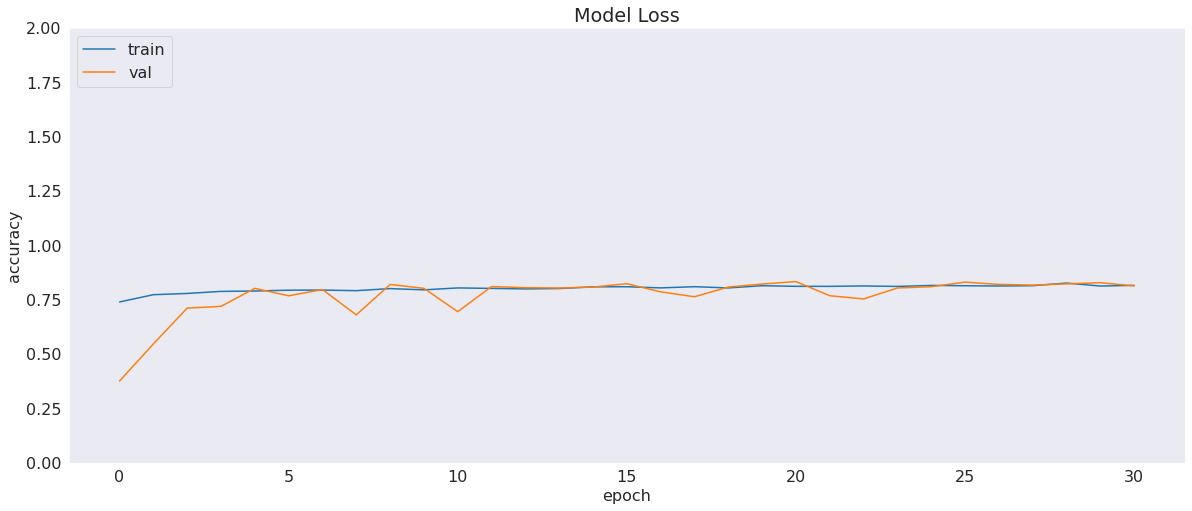

In [25]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = ensemble_model.predict(val_image_samples)

predicted_masks[predicted_masks >= 0.5] = 1
predicted_masks[predicted_masks < 0.5] = 0

# Conclusion
- In some cases the segmented masks do not match with the ground truth mask. The reason behind this is that some of the images were not properly labelled during the data preparation.
- Therefore our model is able to identify certain features that help us segment the forest areas which are not labelled in ground truth images.
- However, the overall performance of our model can be improved by using different metrics relevant to image segmentation